In [1]:
#Show plots inline, and load main getdist plot module and samples class
### Need to run the following twice for some unknown reason. Otherwise plot wouldn't show
from __future__ import print_function
from IPython.display import display, Math
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples, loadMCSamples
import getdist, IPython
import pylab as plt
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
#matplotlib 2 doesn't seem to work well without usetex on
plt.rcParams['text.usetex']=True
import numpy as np
import WLbackground_cosmic_stds as BG
import WLlikelihoods_cosmic_stds as LIKE
import scipy.optimize as op
import emcee
from scipy import integrate
import time
from matplotlib import ticker, cm, patches, pyplot
import pandas as pd

GetDist Version: 1.5.3, Matplotlib version: 3.10.0


In [2]:
def Classifying_Params(Params_Dict):
    Params_va = []
    Params_fixed = []
    for key in Params_Dict.keys():
        if len(Params_Dict[key])==1:
            Params_fixed.append(key)
        else:
            Params_va.append(key)
    return Params_va, Params_fixed

class Parameters:
    def __init__(self, Params_Dict):
        self.Params_va, self.Params_fixed = Classifying_Params(Params_Dict)
        self.Om = Params_Dict['Om'][2] if 'Om' in self.Params_va else Params_Dict['Om'][0]
        self.w0 = Params_Dict['w0'][2] if 'w0' in self.Params_va else Params_Dict['w0'][0]
        self.wa = Params_Dict['wa'][2] if 'wa' in self.Params_va else Params_Dict['wa'][0]
        self.Ok = Params_Dict['Ok'][2] if 'Ok' in self.Params_va else Params_Dict['Ok'][0]
        self.rdH0 = Params_Dict['rdH0'][2] if 'rdH0' in self.Params_va else Params_Dict['rdH0'][0]
        self.DrH0Om05 = Params_Dict['DrH0Om05'][2] if 'DrH0Om05' in self.Params_va else Params_Dict['DrH0Om05'][0]
        self.h = Params_Dict['h'][2] if 'h' in self.Params_va else Params_Dict['h'][0]
        self.zstar = Params_Dict['zstar'][2] if 'zstar' in self.Params_va else Params_Dict['zstar'][0]
        self.Deltazrec = Params_Dict['Deltazrec'][2] if 'Deltazrec' in self.Params_va else Params_Dict['Deltazrec'][0]
        self.Obh2 = Params_Dict['Obh2'][2] if 'Obh2' in self.Params_va else Params_Dict['Obh2'][0]
        self.m_v1 = Params_Dict['m_v1'][2] if 'm_v1' in self.Params_va else Params_Dict['m_v1'][0]
        self.MH0 = Params_Dict['MH0'][2] if 'MH0' in self.Params_va else Params_Dict['MH0'][0]


    def Param_update(self,THETA): ### !!!!!! keep the parameter in the same order
        i=0
        if 'Om' in self.Params_va: self.Om,i = THETA[i], i+1
        if 'w0' in self.Params_va: self.w0,i = THETA[i], i+1
        if 'wa' in self.Params_va: self.wa,i = THETA[i], i+1
        if 'Ok' in self.Params_va: self.Ok,i = THETA[i], i+1
        if 'rdH0' in self.Params_va: self.rdH0, i = THETA[i], i+1
        if 'DrH0Om05' in self.Params_va: self.DrH0Om05, i = THETA[i], i+1
        if 'h' in self.Params_va: self.h, i = THETA[i], i+1
        if 'zstar' in self.Params_va: self.zstar, i = THETA[i], i+1
        if 'Deltazrec' in self.Params_va: self.Deltazrec, i = THETA[i], i+1
        if 'Obh2' in self.Params_va: self.Obh2, i = THETA[i], i+1
        if 'MH0' in self.Params_va: self.MH0, i = THETA[i], i+1
        if 'm_v1' in self.Params_va: self.m_v1, i = THETA[i], i+1
            
def GetMedianStats(samples):
    Percentiles = np.percentile(samples, [15.865, 50, 84.135], axis=0)
    return Percentiles[1], Percentiles[1]-Percentiles[0], Percentiles[2]-Percentiles[1]

In [39]:
def fC_ode(fC,z, p):
    return 1/BG.Ez_KwwaCDM(z,p)  #### change it according to your model here

def fM_from_fC(fCs,p):
    if p.Ok>0:
        fMs = 1./p.Ok**0.5*np.sinh(p.Ok**0.5*fCs)
    elif p.Ok<0:
        fMs = 1./(-p.Ok)**0.5*np.sin((-p.Ok)**0.5*fCs)
    else:
        fMs = fCs
    return fMs   

def zstar_func_Hu1996(p):
    Omh2 = p.Om*p.h**2
    Obh2 = p.Obh2
    g1 = 0.0783*Omh2**(-0.238)/( 1+39.5*Obh2**0.763 )
    g2 = 0.560/( 1 + 21.1*Obh2**1.81 )
    return 1048*( 1+0.00124*Obh2**(-0.738) )*( 1+g1*Omh2**g2 )

def zd_func_Hu1996(p):
    Omh2 = p.Om*p.h**2
    Obh2 = p.Obh2
    b1 = 0.313*Omh2**(-0.419)*( 1 + 0.607*Omh2**0.674 )
    b2 = 0.238*Omh2**0.223
    return 1345*Omh2**0.251/( 1+0.659*Omh2**0.828 )*( 1+b1*Obh2**b2 )

def rH0(p, star_drag=True):
    if star_drag:
        z_end = zstar_func_Hu1996(p)
    else:
        z_end = zd_func_Hu1996(p)
    nll = lambda *args: BG.sound_horizon_integrand(*args)
    temp = integrate.quad(nll, z_end, np.inf, args=(p,))
    return temp[0]

    

def lnlike_SN_prefM_Plus(MH0, fMs, PAN,invC, Marg_M): 
    m_pre = 5*np.log10((1+PAN.zHEL)*fMs)+MH0  
    delta = m_pre-PAN.m_b_corr
    deltaT = np.transpose(delta)
    if Marg_M:
        chi2 = np.sum(delta @ invC @ deltaT)
        B = np.sum(delta @ invC)
        C = np.sum(invC)
        chi2 += - (B**2 / C) + np.log(C / (2 * np.pi))
    else:
        chi2 = np.dot(delta,np.dot(invC,delta))
    return -0.5*chi2

# define UCS likelihood
def lnprob_stds_default(THETA,Params_Dict,zs_input,SN_input,BAO_input,CMB_input):
    use_CMBtheta, CMB_means, CMB_invC, Deltazrec_obs, dDeltazrec_obs, EARLY_PRIOR, UCS_simplified = CMB_input
    use_SN, SN_data, invC, Marg_M = SN_input   # use fast SN likelihood by default
    use_BAO, BAO_datasets_file, BAO_list = BAO_input

    Pall.Param_update(THETA)
    
    if use_SN:
        zs_sn,zs_bao,zs_combined_sorted,index_mapping = zs_input
    else:
        zs_bao, zs_combined_sorted = zs_input

    # priors: 
    out_of_priors=prior_and_SetParameters(Params_Dict, Pall.Params_va, THETA)
    if out_of_priors:
        return -np.inf
    
    lp = 0.0

    if UCS_simplified:
        lp += -0.5*(Pall.DrH0Om05-3.36E-04)**2/(7E-06)**2

    if use_CMBtheta:
        fCs = integrate.odeint(fC_ode,0,zs_combined_sorted.tolist()+[Pall.zstar], args=(Pall,))
        fMs = fM_from_fC(fCs,Pall)    
        lp += -0.5*(Pall.Deltazrec-Deltazrec_obs)**2/(dDeltazrec_obs)**2  
        lp += -0.5*(Pall.Obh2-0.0222)**2/0.0005**2
        fM_cmb = fMs[-1]
        if EARLY_PRIOR:
            rsH0_derived = rH0(Pall, star_drag=True)
            theta_pre = rsH0_derived/fM_cmb
            CMB_pre = np.array([theta_pre[0], Pall.Obh2, Pall.Om*Pall.h**2])
            lp += -0.5*np.dot((CMB_pre-CMB_means),np.dot(CMB_invC,(CMB_pre-CMB_means)))
        else:
            if UCS_simplified:
                rsH0_derived = Pall.rdH0-Pall.DrH0Om05/Pall.Om**0.5
            else:
                rsH0_derived = Pall.rdH0-BG.Delta_rH0(Pall)
            theta_pre = rsH0_derived/fM_cmb
            lp += -0.5*(theta_pre-CMB_means[0])**2/np.linalg.inv(CMB_invC)[0,0]
    else: 
        fCs = integrate.odeint(fC_ode,0,zs_combined_sorted, args=(Pall,))
        fMs = fM_from_fC(fCs,Pall)
    
    
    if use_SN:
        fMs_sn = fMs[index_mapping[1:1+len(zs_sn)]][:,0]
        lp += lnlike_SN_prefM_Plus(Pall.MH0, fMs_sn, SN_data, invC, Marg_M) 
        fMs_bao = fMs[index_mapping[1+len(zs_sn):1+len(zs_sn)+len(zs_bao)]][:,0]
    else:
        fMs_bao = fMs[1:,0]
    
    Es_bao = 1./fC_ode(0,zs_bao, Pall)
    fMs_bao_Dict={}
    for key,value1,value2 in zip(zs_bao,fMs_bao,Es_bao):
        fMs_bao_Dict[key]=[value1,value2]

    if use_BAO:
        lp += LIKE.lnlike_BAO_prefM_grouped_data(Pall.rdH0, fMs_bao_Dict, BAO_datasets_file, BAO_list)

    return lp



def pos_gen(prior):
    return max(prior[0],prior[2]-prior[3])+(min(prior[1],prior[2]+prior[3])
                                         -max(prior[0],prior[2]-prior[3]))*np.random.randint(0,100)/100
    
def prior_and_SetParameters(Params_Dict, Vari_Names,theta):
    out_of_priors = False
    for name, i in zip(Vari_Names,np.arange(len(theta)).tolist()):
        if not (Params_Dict[name][0]<=theta[i]<=Params_Dict[name][1]):
            out_of_priors = True
            return out_of_priors
    return out_of_priors
    

In [44]:
####### Settings:

#### Specify the BAO input:
# Choose to include '6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar'
# and DESI: 'BGS','LRG1','LRG2','LRG3+ELG1','ELG2','QSO','Lya-QSO'



use_BAO = True
BAO_DATA='DESI2025'
BAO_input= [use_BAO, './BAO_data/'+BAO_DATA+'/BAO_DESI2025.txt',['BGS','LRG1','LRG2','LRG3+ELG1','ELG2','QSO','Lya']]
zs_bao=[]
df_BAO = pd.read_csv(BAO_input[1], sep='\t', na_values='-')
zs_bao = df_BAO['zeff'].values.tolist()


#### CMB input:
use_CMBtheta = False
EARLY_PRIOR = False
UCS_simplified = True
if EARLY_PRIOR and UCS_simplified:
    print('EARLY_PRIOR and UCS_simplified cannot be both true')
CMB_means = np.loadtxt('CMB_theta/Planck_theta_means.txt') 
CMB_Cov = np.loadtxt('CMB_theta/Planck_theta_Cov.txt')
if EARLY_PRIOR:
    CMB_means = np.loadtxt('CMB_theta/Planck_summary_DESI_reproduced.txt') 
    CMB_Cov = np.loadtxt('CMB_theta/Planck_summary_DESI_reproduced_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)
Deltaz=3.0265623E+01
dDeltaz=5.7356211E-01
CMB_input=[use_CMBtheta,CMB_means,CMB_invC,Deltaz,dDeltaz,EARLY_PRIOR,UCS_simplified]
### END CMB input


#### load the SN data:
use_SN = False
SN_DATA = 'PanPlus'
if SN_DATA == 'PanPlus':
    SN_path='./PantheonPlus/Pantheon+SH0ES_sort.dat'
    SN_StatSys=np.loadtxt("./PantheonPlus/Pantheon+SH0ES_STAT+SYS_sort.cov")   # systematic errors
elif SN_DATA == 'DESY5':
    SN_path='./DES-SN5YR-main/4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData_sort.dat'
    SN_StatSys=np.loadtxt("./DES-SN5YR-main/4_DISTANCES_COVMAT/STAT+SYS_sort.cov")   # systematic errors
SN_measurements = pd.read_csv(SN_path, sep=" ", header=0)
Index = (SN_measurements['zHD']>0.01) & (SN_measurements['zHD']<10)
SN_measurements = SN_measurements[Index]
C_SN = SN_StatSys    # # including systematic errors
C_SN = C_SN[Index].T[Index] ### select zHD>0.01
Marg_M = False

invC_SN = np.linalg.inv(C_SN)
SN_input=[use_SN,SN_measurements,invC_SN,Marg_M]
#### End loading the SN data


###### Parameter settings:
Params_Dict = { }        # parameter name, min, max, mean, expected error, label
Params_Dict['Om']=[0.01, 0.99, 0.3, 0.003, '\Omega_{m}']
Params_Dict['w0']= [-3, 1, -1, 0.1, 'w_0']
Params_Dict['wa']= [0] #[-3, 2, 0., 0.1, 'w_a']
Params_Dict['Ok']= [0] #[-0.3, 0.3, 0., 0.005, '\Omega_{K}']
Params_Dict['rdH0']=[0.033] #[0.01,0.1, 0.033,0.0003,'r_dH_0']
Params_Dict['DrH0Om05'] = [3.36E-4]   
Params_Dict['h'] = [0.6764] #[0.2,1.0,0.7,0.02,'h']
Params_Dict['zstar']=[1089]
Params_Dict['Deltazrec']=[30]
Params_Dict['Obh2']=[0.0222]
Params_Dict['MH0']=[23.8]
Params_Dict['m_v1']=[0]




if use_BAO:
    if not EARLY_PRIOR:
        Params_Dict['rdH0']=[0.01,0.1, 0.033,0.0003,'r_dH_0']
        


if use_CMBtheta:
    Params_Dict['h']=[0.55,0.88, 0.7, 0.007, 'h']
    if UCS_simplified:
        Params_Dict['DrH0Om05'] = [2.5E-4, 4.5E-4, 3.36E-4, 0.01E-4, '\Delta rH_0\sqrt{\Omega_m}']
    else:
        Params_Dict['Obh2']=[0.01,0.04,0.0222,0.0002, '\Omega_{b}h^2']
        if not EARLY_PRIOR:
            Params_Dict['zstar']=[1070,1120, 1089,5, 'z_*']
            Params_Dict['Deltazrec']=[20,40, 30,0.3, '\Delta z_{rec}']
        

if use_SN:
     Params_Dict['MH0']=[17,30, 23.81,0.2,'MH0']

#####
Pall = Parameters(Params_Dict)
#####
        

#### setting z array, 
if use_SN == True:
    zs_bao_sorted = np.sort(zs_bao)
    zs_sn=SN_measurements['zHD'].values.tolist()    # needs zHD for PanPlus, zcmb for Pan
    zs_combined=np.array([0]+zs_sn+zs_bao)
    zs_combined_sorted=np.sort(zs_combined)
    index_sort = np.argsort(zs_combined)
    index_mapping=np.argsort(index_sort)
    redshifts_input=[zs_sn,zs_bao_sorted,zs_combined_sorted,index_mapping]
else:
    zs_bao_sorted = np.sort(zs_bao)
    zs_combined=np.array([0]+zs_bao)
    redshifts_input=[zs_bao_sorted, zs_combined]



<>:58: SyntaxWarning: invalid escape sequence '\O'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:85: SyntaxWarning: invalid escape sequence '\O'
<>:88: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\O'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:85: SyntaxWarning: invalid escape sequence '\O'
<>:88: SyntaxWarning: invalid escape sequence '\D'
/var/folders/nx/yv71r17j1j589gxl22bvff6m0000gn/T/ipykernel_76256/2335852695.py:58: SyntaxWarning: invalid escape sequence '\O'
  Params_Dict['Om']=[0.01, 0.99, 0.3, 0.003, '\Omega_{m}']
/var/folders/nx/yv71r17j1j589gxl22bvff6m0000gn/T/ipykernel_76256/2335852695.py:83: SyntaxWarning: invalid escape sequence '\D'
  Params_Dict['DrH0Om05'] = [2.5E-4, 4.5E-4, 3.36E-4, 0.01E-4, '\Delta rH_0\sqrt{\Omega_m}']
/var/folders/nx/yv71r17j1j589gxl22bvff6m0000gn/T/ipykernel_76256/2335852695.py:85: SyntaxWarning: invalid escape sequence '\O'
  Params_Dict['Obh2']=[0.01,0.04,0.0222,0.0002, '\Omega_{b}

In [45]:
#### Specify the output name prefix
PATH = './chains_DESI2025/raw_chains_simplified/'
save_chain_name = ''
if use_BAO:
    save_chain_name+='BAO-'+BAO_DATA
if use_CMBtheta:
    save_chain_name+='_CMB'
    if EARLY_PRIOR:
        save_chain_name+='-EarlyPr'
    if UCS_simplified:
        save_chain_name+='-Smp'
if use_SN:
    save_chain_name+='_SN-'+SN_DATA
EX_prefix = '_wCDM'
save_chain_name+=EX_prefix
save_chain_file=PATH+save_chain_name
#### END specifying the output name
print(save_chain_file)

./chains_DESI2025/raw_chains_simplified/BAO-DESI2025_wCDM


In [46]:
p_va, p_fixed = Classifying_Params(Params_Dict)
pos=[[pos_gen(Params_Dict[key]) for key in p_va] for i in range(32)]
print(Pall.Params_va)
lnprob_stds_default(pos[0],Params_Dict,redshifts_input,SN_input,BAO_input,CMB_input)

['Om', 'w0', 'rdH0']


0   -35.754457
Name: zeff, dtype: float64

In [47]:
# Run the MCMC

p_va, p_fixed = Classifying_Params(Params_Dict)
ndim, nwalkers, nstep = len(p_va), 64, 10000  # settings for emcee


# The following is to run MCMC:
# initial position

pos=[[pos_gen(Params_Dict[key]) for key in p_va] for i in range(nwalkers)]


sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds_default, 
                                       args=(Params_Dict,redshifts_input,SN_input,BAO_input,CMB_input))


sampler_combined.run_mcmc(pos, nstep, progress=True,);
sampler_dict = {
    'chain': sampler_combined.chain,
    'log_prob': sampler_combined.lnprobability,
    'blobs': sampler_combined.blobs,
    'state': sampler_combined.random_state,
}

# Save to .npy file
np.save(save_chain_file+'.npy', sampler_dict, allow_pickle=True)
np.save(PATH+'/Params_Priors/'+save_chain_name+'_ParamDict.npy', Params_Dict) 

100%|█████████████████████████████████████| 10000/10000 [25:41<00:00,  6.49it/s]


Removed no burn in


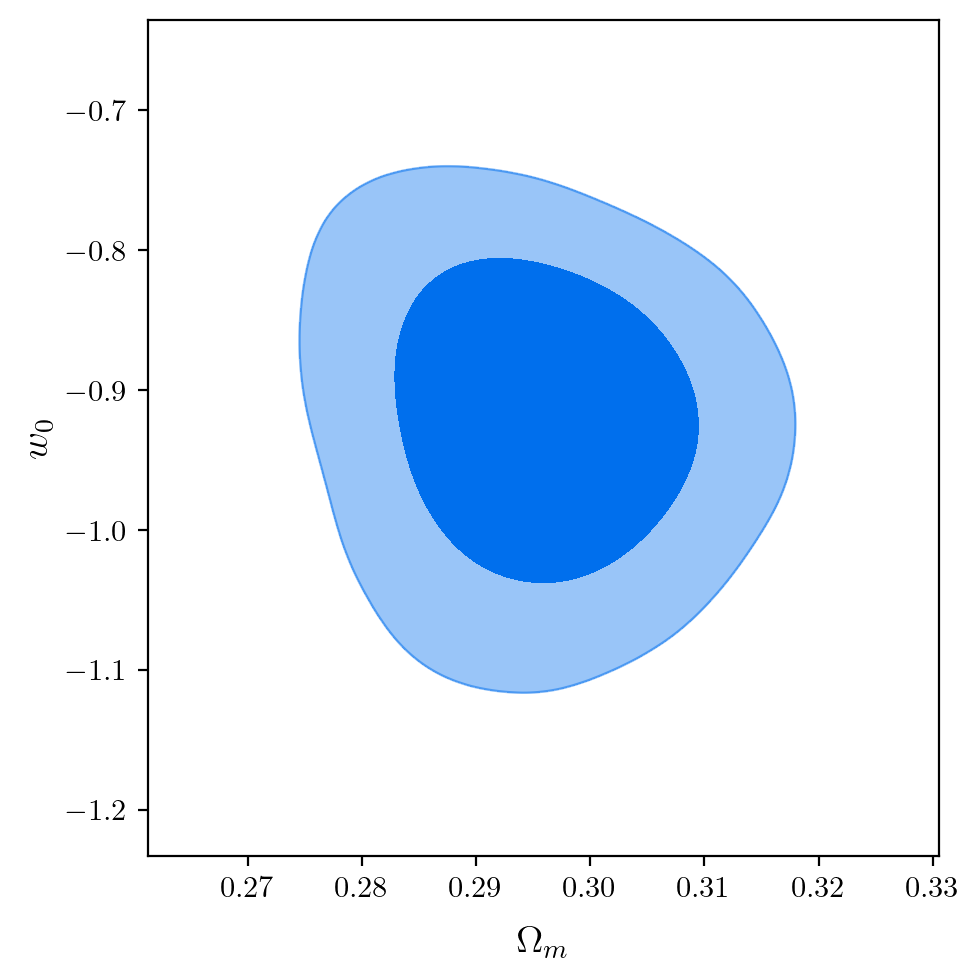

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
#### Plot the result:
g = plots.getSinglePlotter(width_inch=5, ratio=1)

#### Specify the chain to plot:
load_chain_file=save_chain_file+'.npy'
sampler = np.load(load_chain_file, allow_pickle=True).item()

#### Load the chain:

samples = sampler['chain'][:, :, :].reshape((-1, len(Pall.Params_va)))   #filter out first XXX rows

#### Axis labels for the parameters
MCsamples = MCSamples(samples=samples,names = Pall.Params_va, 
                      labels=[Params_Dict[key][-1] for key in Pall.Params_va],
                      ranges={ key: Params_Dict[key][0:2] 
                              for key in Pall.Params_va },ignore_rows=0)
g.plot_2d(MCsamples, 'Om', 'w0',filled=True)
plt.axvline(x=-1, ls=':', color='k')
plt.axhline(y=0, ls=':', color='k')
g.export('figures_DESI2025/Pan/w0-wa_UCS_EarlyPrior.pdf')
plt.show()
# print(MCsamples.getMargeStats())

Medians, Lows, Ups = GetMedianStats(samples)
# print('Median+upper-lower:')
# display median + upper -lower of C
for median, low, up, PARAM in zip(Medians, Lows, Ups, Pall.Params_va):
    txt = "{3} = {{{0: 2.5f}}}^{{+{1: .5f}}}_{{-{2: .5f}}}"
    txt = txt.format(median, low, up, Params_Dict[PARAM][-1])
    display(Math(txt))

<Figure size 500x500 with 0 Axes>

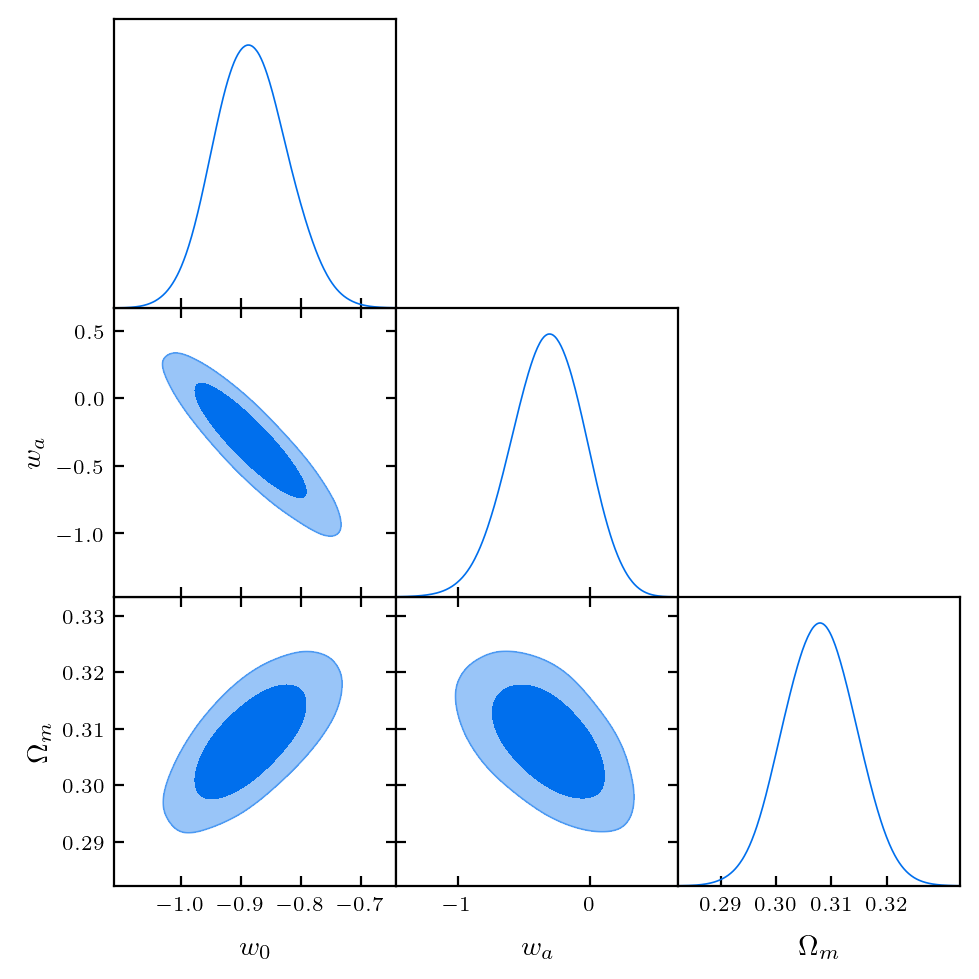

In [59]:
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, ['w0','wa','Om'],filled=True)
g.export('figures_DESI2025/w0-wa-Om_UCS.pdf')
plt.show()

In [42]:
(0.0457*0.0736**2/0.510)**(1/3)

0.07858998711122364

In [66]:
kf=1.47E17/2.4E18
deltai = 1/kf**1.5*np.exp(-1/kf)
deltai

np.float64(5.355730397670249e-06)